Extract cell type embeddings from fixed  embedding layer of the trained model.

In [2]:
import os
import math
import torch
import pickle
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from braceexpand import braceexpand
from tqdm import tqdm
import umap
from sklearn.decomposition import PCA

# for flex attention
import torch._dynamo
torch._dynamo.config.suppress_errors = True

# DEVICE = torch.device('cuda:1')
DEVICE = torch.device('cuda:0')
sc.set_figure_params(figsize=(4, 4))

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext, \
    GeneNetworkAnalysisBase

In [4]:
ROOT_PATH = "/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm"
TRAIN_ROOT_PATH = "/work/hdd/bbjr/mallina1/data/human_cellariumgpt_v2/extract_files"
CHECKPOINT_PATH = "/work/hdd/bbjr/mallina1/cellarium/models/latest/epoch=5-step=452000.ckpt"

REF_ADATA_PATH = os.path.join(ROOT_PATH, "data", "extract_0.h5ad")
GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")
ONTOLOGY_INFO_PATH = os.path.join(ROOT_PATH, "ontology_infos.pt")
ONTOLOGY_DIR_PATH = os.path.join(ROOT_PATH, "ontology")

ctx = CellariumGPTInferenceContext(
    cellarium_gpt_ckpt_path=CHECKPOINT_PATH,
    ref_adata_path=REF_ADATA_PATH,
    gene_info_tsv_path=GENE_INFO_PATH,
    device=DEVICE,
    attention_backend="mem_efficient"
)

In [17]:
ontology_infos = torch.load(ONTOLOGY_INFO_PATH)
cell_type_labels = ontology_infos['cell_type']['labels']
cell_type_names = ontology_infos['cell_type']['names']

with open(os.path.join(ONTOLOGY_DIR_PATH, 'cl_benchmarking_resource.pkl'), 'rb') as fp:
    cell_type_benchmarking = pickle.load(fp)

# with open(os.path.join(ONTOLOGY_DIR_PATH, 'cl_propagation_resource.pkl'), 'rb') as fp:
#     cell_type_propagation = pickle.load(fp)

cl_label2name = {}
cl_name2label = {}

for idx in range(len(cell_type_labels)):
    cl_label2name[cell_type_labels[idx]] = cell_type_names[idx]
    cl_name2label[cell_type_names[idx]] = cell_type_labels[idx]

/tmp/ipykernel_290983/398718590.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ontology_infos = torch.load(ONTOLOGY_INFO_PATH)


In [22]:
print(cell_type_benchmarking.keys())
print(cell_type_names[0], cell_type_labels[0])
print(cell_type_labels)

cl_name2label['CL:0000540']

print(cell_type_benchmarking['CL:0000101'].keys())

dict_keys(['CL:0000000', 'CL:0000540', 'CL:0000101', 'CL:0000001', 'CL:0000010', 'CL:0000005', 'CL:0000333', 'CL:0000057', 'CL:0000006', 'CL:0000197', 'CL:0002321', 'CL:0000578', 'CL:0000039', 'CL:0000034', 'CL:0000015', 'CL:0000586', 'CL:0000413', 'CL:0000019', 'CL:0000408', 'CL:0000021', 'CL:0000023', 'CL:0000255', 'CL:0000024', 'CL:0000670', 'CL:0000412', 'CL:0000192', 'CL:0000029', 'CL:0000030', 'CL:0000055', 'CL:0000031', 'CL:0000114', 'CL:0000152', 'CL:0011115', 'CL:0000035', 'CL:0000723', 'CL:0000036', 'CL:0000037', 'CL:0000988', 'CL:0008001', 'CL:0011026', 'CL:0000038', 'CL:0000764', 'CL:0000839', 'CL:0000050', 'CL:0002194', 'CL:0000763', 'CL:0002009', 'CL:0000771', 'CL:0000145', 'CL:0000834', 'CL:0000767', 'CL:0002274', 'CL:0000051', 'CL:0000047', 'CL:0002319', 'CL:0000048', 'CL:0000049', 'CL:0002032', 'CL:0000557', 'CL:0000151', 'CL:0000056', 'CL:0000680', 'CL:0002320', 'CL:0000134', 'CL:0002077', 'CL:0000710', 'CL:0000062', 'CL:0007010', 'CL:0000064', 'CL:0000065', 'CL:00000

In [23]:
cell_type_embedding = ctx.gpt_pipeline.model.metadata_embedding.E['cell_type'].weight.cpu().detach().numpy()
cell_type_embedding.shape

cell_type_embedding = cell_type_embedding[:len(cell_type_labels),:]

In [5]:
# np.save('/u/mallina1/cell_type_embedding.npy', cell_type_embedding)

# Prep for CSV data format that is used in Poincare VAE codebase
header = [f'feature_{idx}' for idx in range(512)] + ['cell_type_idx']
header = ','.join(header)
np.savetxt('/u/mallina1/cell_type_embedding.csv',
           np.concatenate((cell_type_embedding, np.arange(cell_type_embedding.shape[0]).reshape(-1, 1)), axis=1), 
           delimiter=',',
           header=header,
           comments="")

In [6]:
pca = PCA(n_components=2)
X_ct_pca = pca.fit_transform(cell_type_embedding)

In [42]:
# plt.scatter(X_ct_pca[:,0], X_ct_pca[:,1])
df = pd.DataFrame({'x': X_ct_pca[:,0], 'y': X_ct_pca[:, 1], 'label': cell_type_labels})

fig = px.scatter(df, x='x', y='y', hover_data='label', width=500, height=500)
fig.show()
fig.write_html("pca_cell_type_emb.html")

In [31]:
reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.0, metric='euclidean')
X_ct_umap = reducer.fit_transform(cell_type_embedding)

In [ ]:
# plt.scatter(X_ct_umap[:,0], X_ct_umap[:,1])

label_to_color = 'astrocyte'
cl_name = cl_label2name[label_to_color]
descendants = cell_type_benchmarking[cl_name]['all_descendants']
pd_tree_col = []
pd_tree_size_col = []
for cl_label in cell_type_labels:
    if cl_label2name[cl_label] in descendants or cl_label == label_to_color:
        pd_tree_col.append(cl_label)
        pd_tree_size_col.append(2.0)
    else:
        pd_tree_col.append(f'NOT IN {label_to_color.upper()} DESCENDANTS')
        pd_tree_size_col.append(0.5)

df = pd.DataFrame({'x': X_ct_umap[:,0], 'y': X_ct_umap[:, 1], 'label': cell_type_labels, f'{label_to_color} descendants': pd_tree_col})

fig = px.scatter(df, x='x', y='y', hover_data='label', width=750, height=500, color=f'{label_to_color} descendants')
fig.show()

/tmp/ipykernel_290983/2620288918.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(hyperbolic_mapper.embedding_.T[0],


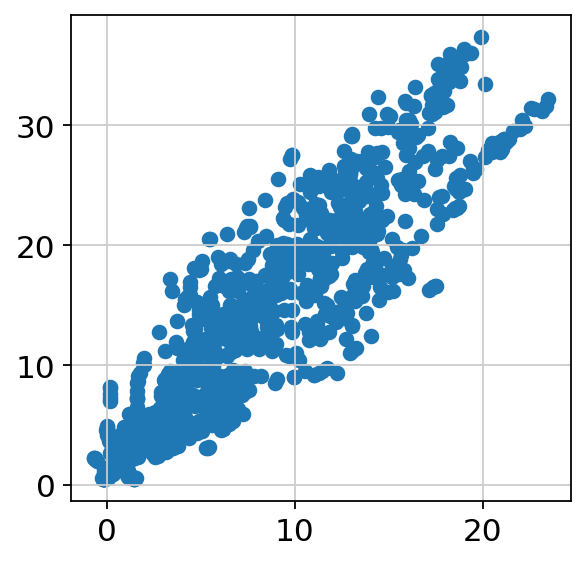

In [ ]:
hyperbolic_mapper = umap.UMAP(output_metric='hyperboloid').fit(cell_type_embedding)
plt.scatter(hyperbolic_mapper.embedding_.T[0],
            hyperbolic_mapper.embedding_.T[1])

In [26]:
x = hyperbolic_mapper.embedding_[:, 0]
y = hyperbolic_mapper.embedding_[:, 1]
z = np.sqrt(1 + np.sum(hyperbolic_mapper.embedding_**2, axis=1))

disk_x = x / (1 + z)
disk_y = y / (1 + z)

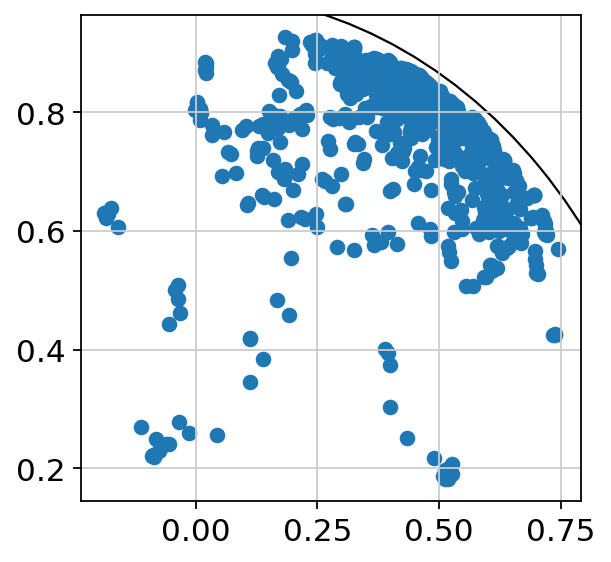

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(disk_x, disk_y)
boundary = plt.Circle((0,0), 1, fc='none', ec='k')
ax.add_artist(boundary)
# ax.axis('off');